# B cell analysis

Zoë Steier

* Dataset: SLN-all (spleen and lymph node, two days, two panels)
* Explore B cell heterogeneity through clusters and tissues
* Explore RNA/protein markers from the literature
* Quantify differences between clusters with DE
* Calculate intra-cluster feature correlations

## Imports and settings

In [1]:
# Import required packages

import os
import seaborn as sns
import numpy as np
import torch

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted
import matplotlib.colors
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from plotnine import *
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

set_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

## Load data

In [4]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

In [5]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)

[2020-05-06 18:04:51,742] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 18:04:51,749] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 18:04:52,412] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 18:04:53,207] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells
[2020-05-06 18:04:56,718] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 18:04:56,722] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 18:04:56,957] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 18:04:57,074] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-05-06 18:04:57,697] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-05-06 18:04:58,361] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 18:04:58,567] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 1

In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 32648 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'batch_indices', 'protein_expression', 'local_means', 'labels'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

## Load and evaluate totalVI model

In [7]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
)

In [8]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/sln_all_intersect.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4119, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [9]:
use_cuda = True
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Load model results

In [10]:
post_adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/totalVI/sln_all_intersect_results_post_adata.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [11]:
post_adata

AnnData object with n_obs × n_vars = 32648 × 4005 
    obs: 'leiden_totalVI_1.0', 'leiden_totalVI_0.8', 'leiden_totalVI_0.6', 'leiden_totalVI_0.4', 'annotations', 'leiden_subclusters', 'batch_indices', 'n_genes', 'n_protein_counts', 'n_proteins', 'n_RNA_counts', 'percent_mito', 'seurat_hash_id', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', '

In [12]:
# Add in cell type labels (abbreviated)

cell_types = np.concatenate((anndataset_111.obs["cell_types"], anndataset_206.obs["cell_types"]))
post_adata.obs["cell_types"] = cell_types

## Scanpy normalization of RNA to plot raw data

In [13]:
# Normalize for library size (adjust to 10,000 counts/cell)
sc.pp.normalize_per_cell(post_adata, counts_per_cell_after=1e4)

# Log the data
sc.pp.log1p(post_adata)

# Save log(raw) as adata.raw
post_adata.raw = post_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [14]:
# Cell filtering to remove doublets and low quality cells

include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in post_adata.obs["leiden_subclusters"]
]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'cell_types' as categorical


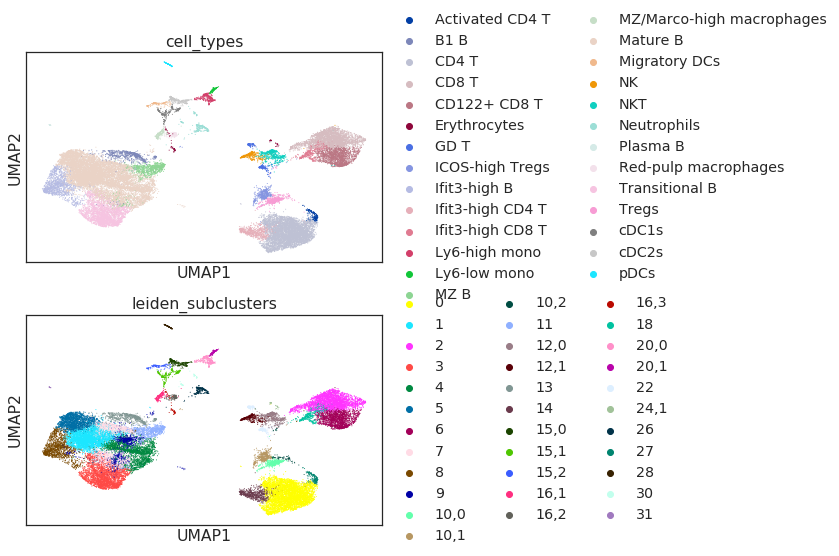

In [21]:
sc.pl.umap(
    post_adata[include_cells], 
    color=["cell_types", "leiden_subclusters"], 
    ncols=1, 
)

## Explore B cell clusters and tissues

In [15]:
# Subset on B cell clusters

Bclusters = [
    c in ["1", "3", "4", "5", "7", "8", "9", "11", "13"]
    for c in post_adata.obs["leiden_subclusters"]
]

In [16]:
# Use this ordering of cell types for consistency

Bcell_clust_onevall = ['Transitional B', 'Mature B', 'Ifit3-high B', 'B1 B', 'MZ B']

### Collect B cell data in anndata objects
From anndata, make can make scanpy matrixplot and plot denoised values.

In [61]:
# Make anndata object for denoised RNA

Brna_adata = anndata.AnnData(post_adata.X)[Bclusters,:]
Brna_adata.var.index = post_adata.uns["totalVI_genes"]
Brna_adata.raw = Brna_adata

Brna_adata.X = (post_adata.obsm["denoised_genes"][Bclusters,:])
Brna_adata.obs["leiden_subclusters"] = post_adata.obs["leiden_subclusters"][Bclusters].values
Brna_adata.obs["cell_types"] = pd.Series(post_adata.obs["cell_types"][Bclusters]).astype("category").values

# Reorder the categories so they can be plotted with a dictionary
Brna_adata.obs["cell_types"] = Brna_adata.obs["cell_types"].cat.reorder_categories(Bcell_clust_onevall)

Brna_adata.obs["annotations"] = post_adata.obs["annotations"][Bclusters].values
Brna_adata.obs["seurat_hash_id"] = post_adata.obs["seurat_hash_id"][Bclusters].values

Brna_adata.obsm["X_umap"] = post_adata.obsm["X_umap"][Bclusters,:]
Brna_adata.obsm["X_totalVI"] = post_adata.obsm["X_totalVI"][Bclusters,:]

In [62]:
# Make anndata object for denoised proteins

Bprotein_adata = anndata.AnnData(np.log1p(dataset.protein_expression))[Bclusters,:]
Bprotein_adata.var.index = post_adata.uns["totalVI_proteins"]
Bprotein_adata.raw = Bprotein_adata

Bprotein_adata.X = post_adata.obsm["denoised_proteins"][Bclusters,:]
Bprotein_adata.obs["leiden_subclusters"] = post_adata.obs["leiden_subclusters"][Bclusters].values
Bprotein_adata.obs["cell_types"] = pd.Series(post_adata.obs["cell_types"][Bclusters]).astype("category").values

# Reorder the categories so they can be plotted with a dictionary
Bprotein_adata.obs["cell_types"] = Bprotein_adata.obs["cell_types"].cat.reorder_categories(Bcell_clust_onevall)

Bprotein_adata.obs["annotations"] = post_adata.obs["annotations"][Bclusters].astype("category").values
Bprotein_adata.obs["seurat_hash_id"] = post_adata.obs["seurat_hash_id"][Bclusters].values

Bprotein_adata.obsm["X_umap"] = post_adata.obsm["X_umap"][Bclusters,:]
Bprotein_adata.obsm["X_totalVI"] = post_adata.obsm["X_totalVI"][Bclusters,:]

In [26]:
Brna_adata.X.shape

(15560, 4005)

### Minimal filtering of outliers for plotting

Filter 9 outlier cells.
Where are the outliers? 7 cluster with B doublets, 2 cluster with B-CD8T doublets (9 cells in total).

In [63]:
# Filter B cells with UMAP1 > -1

umap_filt = Brna_adata.obsm["X_umap"][:, 0] < -1.1
Brna_adata = Brna_adata[umap_filt, :]
Bprotein_adata = Bprotein_adata[umap_filt, :]

Brna_adata.X.shape

(15551, 4005)

### Plot B cell clusters and tissues

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


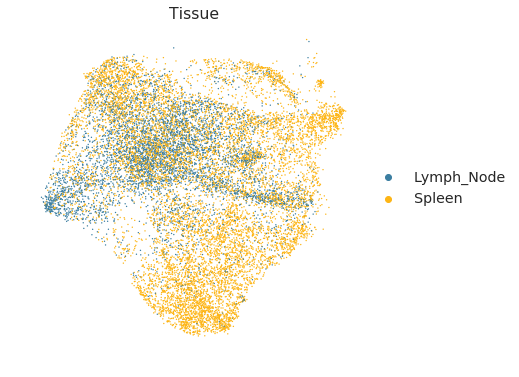

In [29]:
# Plot spleen LN tissue on B cells

fig, ax = plt.subplots(figsize=(6, 6))

sc.pl.umap(
    Brna_adata, 
    color= ["seurat_hash_id"],
    frameon=False,
    title="Tissue",
    ax=ax,
)

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Bcell_umap_tissue.pdf", dpi=DPI, bbox_inches='tight')

In [30]:
# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
spleen = [Brna_adata.obs["seurat_hash_id"] == "Spleen"]
LN = [Brna_adata.obs["seurat_hash_id"] == "Lymph_Node"]

# Get cluster labels
spleen_clusters = pd.Series((Brna_adata.obs["cell_types"].values)[spleen])
LN_clusters = pd.Series((Brna_adata.obs["cell_types"].values)[LN])

# Calculate cluster composition (cells as a percent of total in that tissue)
spleen_comp  = spleen_clusters.value_counts()/np.sum(spleen_clusters.value_counts())*100
LN_comp = LN_clusters.value_counts()/np.sum(LN_clusters.value_counts())*100

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2149: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values=self._codes[key], dtype=self.dtype, fastpath=True


In [32]:
# Reorder LN clusters to match spleen

order_clusters = [cluster for cluster in spleen_comp.index.values]
LN_comp = LN_comp.loc[order_clusters]

In [35]:
# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"Spleen":spleen_comp, "Lymph Node": LN_comp}))
composition_df

,Mature B,Transitional B,MZ B,B1 B,Ifit3-high B
Spleen,57.340405,23.962872,8.420155,5.341921,4.934647
Lymph Node,77.608652,4.105748,0.781094,1.922692,15.581815


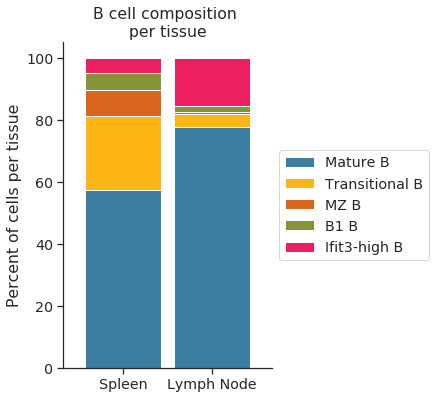

In [46]:
# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85),
plt.ylabel("Percent of cells per tissue")
plt.title("B cell composition \nper tissue")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Bcell_composition_per_tissue.pdf", dpi=DPI, bbox_inches='tight')

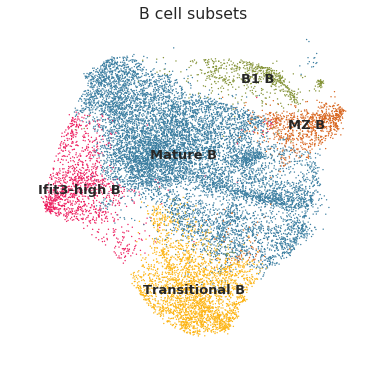

In [37]:
# Plot cluster annotations on B cells

fig, ax = plt.subplots(figsize=(6, 6))

sc.pl.umap(
    Brna_adata, 
    color= "cell_types",
    palette = [colors[i] for i in np.argsort(composition_df.columns)],
    frameon=False,
    title="B cell subsets",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax,
)

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Bcell_umap_clusters.pdf", dpi=DPI, bbox_inches='tight')

## RNA and protein expression of key B cell markers

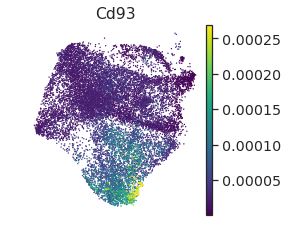

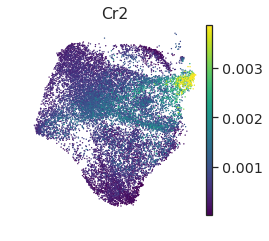

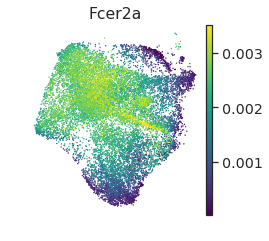

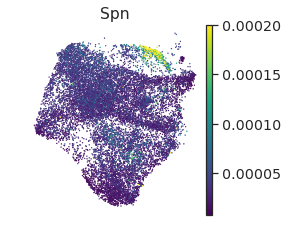

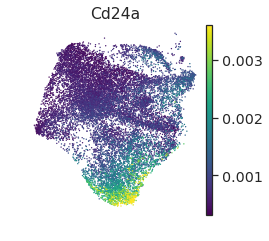

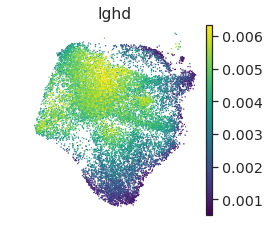

In [49]:
# Plot RNA

for RNA in ["Cd93", 'Cr2', "Fcer2a", 'Spn', "Cd24a", "Ighd"]:
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    sc.pl.umap(
        Brna_adata, 
        use_raw = False,
        color=RNA,
        ncols=1, 
        color_map = "viridis", 
        frameon = False,
        ax = ax,
        vmax = "p99.5",
        vmin = "p0.5"
    )
    
    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/%s_umap_RNA_denoised.pdf" % RNA, dpi=DPI, bbox_inches='tight')

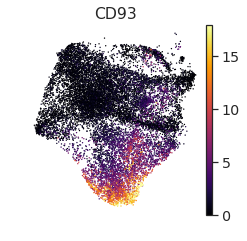

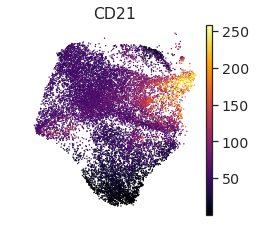

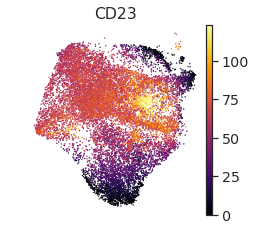

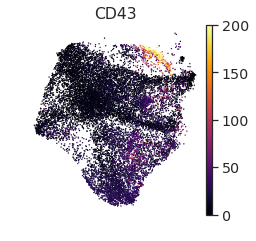

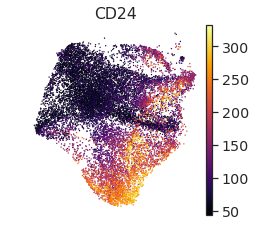

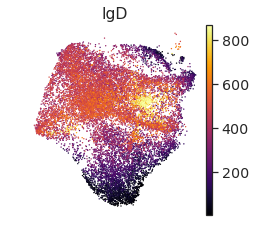

In [50]:
# Plot protein

RNA = ["Cd93", 'Cr2', "Fcer2a", 'Spn', "Cd24a", "Ighd"]
protein = ["ADT_CD93(AA4.1_earlyBlineage)_A0113", 'ADT_CD21-CD35(CR2-CR1)_A0107','ADT_CD23_A0108', "ADT_CD43_A0110",
          "ADT_CD24_A0212", "ADT_IgD_A0571"]
prot_titles = ["CD93", "CD21", "CD23", "CD43", "CD24", "IgD"]

for i in range(len(protein)):
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    sc.pl.umap(
        Bprotein_adata, 
        use_raw = False,
        color=protein[i], 
        title = prot_titles[i],
        ncols=1, 
        color_map = "inferno", 
        frameon = False,
        ax = ax,
        vmax = "p99.5",
        vmin = "p0.5"
    )
    
    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/%s_umap_protein_denoised.pdf" % RNA[i], dpi=DPI, bbox_inches='tight')

## DE test of B cell RNA and proteins

In [22]:
# Generate posterior on all cells from totalVI model

full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [23]:
# one-vs-all DE test on B cell clusters

Bcell_res_onevall, Bcell_clust_onevall = full_posterior.one_vs_all_degenes(
    subset = Bclusters,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [54]:
# B cell clusters
Bcell_clust_onevall

['Transitional B', 'Mature B', 'Ifit3-high B', 'B1 B', 'MZ B']

In [24]:
# Concatenate DE results across clusters to make filtering and viewing easier
all_de = pd.concat(Bcell_res_onevall) 

In [297]:
# Save DE results
all_de.to_csv("DE_onevall_Bcells.csv")

### Exploration of DE results

In [56]:
# View snapshot of DE results
# mean is the expectation of the LFC
# median is the median of the LFC

all_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Wfdc21,0.9916,0.0084,4.771087,0.000471,2.221080e-05,5.702124,5.849920,2.811344,-5.699721,14.569172,...,10.936937,-1.939546,12.217588,0.377331,0.033918,0.194516,0.014737,1.721405,0.084566,Transitional B
Gm14964,0.9876,0.0124,4.377580,0.000041,4.855638e-06,3.520634,3.556338,1.835379,-3.835510,10.745325,...,6.972105,-1.356728,8.489163,0.047532,0.006784,0.041682,0.005848,0.190044,0.019153,Transitional B
Cplx2,0.9852,0.0148,4.198217,0.000093,8.929239e-06,3.851156,3.883867,2.203186,-4.812025,12.702986,...,8.132752,-2.181617,9.077588,0.086654,0.009825,0.072395,0.008889,0.386106,0.029311,Transitional B
Col5a3,0.9832,0.0168,4.069433,0.000035,7.968706e-07,4.444665,4.342880,3.150443,-6.495152,16.092731,...,10.787029,-2.879615,13.301885,0.031444,0.001092,0.023035,0.000780,0.141140,0.002084,Transitional B
Nrxn2,0.9822,0.0178,4.010596,0.000029,2.811385e-06,3.718404,3.732101,2.005864,-5.462520,11.362570,...,7.686785,-1.772287,8.819888,0.028519,0.003275,0.026691,0.002885,0.126306,0.008744,Transitional B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADT_CD103_A0201,0.0052,0.9948,-5.253881,0.526180,5.323416e-01,-0.003389,0.000000,0.321461,-5.742082,5.763044,...,0.000000,0.000000,0.000000,5.112069,4.758201,0.991379,0.989612,NaN,NaN,MZ B
ADT_TCRbchain_A0120,0.0048,0.9952,-5.334326,0.664066,5.222005e-01,0.016780,0.000000,0.423015,-6.074725,7.594746,...,0.000000,0.000000,0.000000,2.798491,2.770913,0.922414,0.905208,NaN,NaN,MZ B
ADT_TCRVr2_A0211,0.0040,0.9960,-5.517450,0.509007,5.100770e-01,-0.001200,0.000000,0.213125,-3.973154,4.143557,...,0.000000,0.000000,0.000000,2.328664,2.351627,0.895474,0.900014,NaN,NaN,MZ B
ADT_NK-1.1_A0118,0.0022,0.9978,-6.117091,0.504922,5.100629e-01,-0.002346,0.000000,0.175736,-5.295511,4.298551,...,0.000000,0.000000,0.000000,2.295259,2.150629,0.894397,0.867961,NaN,NaN,MZ B


In [59]:
# Inspect a cluster for DE RNA

cluster = "Transitional B"
RNA_de_filt = all_de.loc[all_de['non_zeros_proportion1'] > 0.1] # select non_zeros_proportion1 > 0.1 for RNA
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['mean'] > 0] # select mean > 0 (positive fold change)
RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 0.7] # select bayes_factor > 0.7, which is DE
RNA_de_filt = RNA_de_filt.sort_values(by = "median", ascending = False) # sort by median LFC
RNA_de_filt = RNA_de_filt[["ADT" not in x for x in np.array(RNA_de_filt.index)]] # exclude proteins

RNA_de_filt.iloc[(RNA_de_filt[["clusters"]] == cluster).values.ravel(), :][:10] # top 10 

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Wfdc21,0.9916,0.0084,4.771087,0.000471,0.000022,5.702124,5.849920,2.811344,-5.699721,14.569172,...,10.936937,-1.939546,12.217588,0.377331,0.033918,0.194516,0.014737,1.721405,0.084566,Transitional B
Hivep3,0.9786,0.0214,3.822732,0.000353,0.000072,2.615613,2.692410,1.551300,-3.907461,8.042638,...,5.631813,-1.833555,6.007265,0.351737,0.093255,0.238391,0.064795,1.447210,0.275711,Transitional B
Cfp,0.9646,0.0354,3.305001,0.000176,0.000045,2.448684,2.508323,1.876200,-4.384830,8.316479,...,5.986071,-2.313278,6.999209,0.213894,0.074464,0.159415,0.055517,0.732870,0.182706,Transitional B
Dusp10,0.9738,0.0262,3.615446,0.000156,0.000029,2.387567,2.430880,1.304402,-2.348159,6.620148,...,4.899995,-0.871722,5.537060,0.194881,0.038908,0.148446,0.034932,0.688197,0.105775,Transitional B
Serinc5,0.9704,0.0296,3.489934,0.000175,0.000030,2.384221,2.284079,1.606323,-4.788547,9.462667,...,5.553018,-1.608804,6.898731,0.168921,0.031657,0.133090,0.028460,0.757139,0.107837,Transitional B
Nedd4,0.9630,0.0370,3.259135,0.000276,0.000080,2.137094,2.241039,1.370742,-3.044151,5.934191,...,4.629372,-1.722490,5.114397,0.311517,0.115634,0.248629,0.089279,1.199299,0.311423,Transitional B
Fam129c,0.9644,0.0356,3.299160,0.000549,0.000135,2.030068,2.066841,1.403459,-3.050922,5.924830,...,4.755085,-1.772985,5.288870,0.639854,0.216296,0.382084,0.142300,2.357425,0.562869,Transitional B
Akap12,0.9640,0.0360,3.287572,0.000319,0.000065,2.101216,2.024466,1.382036,-3.452022,7.519050,...,5.002548,-1.516450,5.838756,0.318099,0.077427,0.213163,0.062378,1.289344,0.255118,Transitional B
Sik1,0.9600,0.0400,3.178054,0.000113,0.000031,1.906866,1.957799,1.132443,-2.325758,5.653502,...,3.919792,-1.169820,4.542122,0.143693,0.046784,0.124680,0.041949,0.511607,0.126876,Transitional B
Hck,0.9528,0.0472,3.005011,0.000656,0.000187,1.824525,1.855989,1.253286,-3.439103,6.154490,...,4.220085,-1.517851,4.908297,0.732724,0.248031,0.447898,0.181131,2.797375,0.789624,Transitional B


In [60]:
# Inspect a cluster for DE protein

cluster = "Transitional B"
protein_de_filt = all_de[["ADT" in x for x in np.array(all_de.index)]] # select proteins
protein_de_filt = protein_de_filt.loc[protein_de_filt['mean'] > 0] # select mean > 0 (positive fold change)
protein_de_filt = protein_de_filt.loc[protein_de_filt['bayes_factor'] > 0.7] # select bayes_factor > 0.7, which is DE
protein_de_filt = protein_de_filt.sort_values(by = "median", ascending = False) # sort by median LFC
protein_de_filt.iloc[(protein_de_filt[["clusters"]] == cluster).values.ravel(), :].iloc[0:20,:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.6842,0.3158,0.773141,5.744096,1.132021,2.073270,2.962296,2.242721,-5.279881,5.816191,...,5.367306,-3.610644,5.668886,6.263985,2.464483,0.949909,0.880390,NaN,NaN,Transitional B
ADT_CD24_A0212,0.9370,0.0630,2.699548,180.035126,82.679901,1.257646,1.401525,0.920460,-6.859623,8.787938,...,2.706390,-1.201872,2.926069,174.998535,84.786201,1.000000,0.999922,NaN,NaN,Transitional B
ADT_CD102_A0104,0.8442,0.1558,1.689816,64.618996,48.630981,0.501995,0.551731,0.772853,-8.426184,7.716413,...,1.414422,-1.410419,1.764215,63.757954,48.748459,1.000000,1.000000,NaN,NaN,Transitional B
ADT_CD20_A0192,0.8564,0.1436,1.785706,21.538769,16.520636,0.360875,0.511786,1.018769,-6.539793,6.296001,...,1.628861,-5.263699,1.860446,21.090677,16.553684,1.000000,1.000000,NaN,NaN,Transitional B
ADT_CD71_A0441,0.8636,0.1364,1.845518,20.648951,16.864077,0.252636,0.496350,1.259592,-6.823373,6.010321,...,1.993584,-5.900662,1.993584,20.306032,16.874853,0.999634,0.999454,NaN,NaN,Transitional B
ADT_CD48_A0429,0.7446,0.2554,1.070016,52.378674,46.642056,0.217566,0.287904,0.600332,-6.412550,7.313104,...,1.155492,-1.551157,1.299776,52.155029,46.736454,1.000000,1.000000,NaN,NaN,Transitional B
ADT_CD54_A0074,0.8174,0.1826,1.498831,22.906271,24.314415,0.074740,0.197032,0.827772,-3.653476,2.459103,...,1.484131,-2.414761,1.819270,22.336746,24.416296,0.999634,0.999220,NaN,NaN,Transitional B
ADT_CD29_A0570,0.7770,0.2230,1.248269,13.906914,13.377086,0.684801,0.179580,2.436811,-7.651981,6.616134,...,5.785573,-5.782760,5.959027,14.012066,15.221989,0.999634,0.999376,NaN,NaN,Transitional B
ADT_CD43_A0110,0.7128,0.2872,0.909022,18.772739,14.972822,1.949676,0.152567,3.932587,-9.673027,8.262002,...,6.519729,-7.819591,7.001482,22.360878,22.930527,1.000000,0.999532,NaN,NaN,Transitional B


In [63]:
# View one gene in all clusters

all_de.loc["Cd93"]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Cd93,0.9540,0.0460,3.032022,0.000095,0.000028,1.927549,1.864002,1.475975,-3.663672,10.307274,...,4.759563,-1.506594,6.351648,0.098720,0.033294,0.087386,0.031735,0.398010,0.111849,Transitional B
Cd93,0.9246,0.0754,2.506554,0.000031,0.000057,-0.501579,-0.646018,2.060100,-8.694670,8.449630,...,3.696907,-5.878026,5.369047,0.036131,0.060100,0.034622,0.053698,0.125631,0.226662,Mature B
Cd93,0.9074,0.0926,2.282294,0.000024,0.000042,-0.462475,-0.479439,1.681363,-6.937861,6.415680,...,2.975628,-4.446894,4.420883,0.019985,0.047058,0.019216,0.043551,0.070987,0.170465,Ifit3-high B
Cd93,0.9128,0.0872,2.348312,0.000020,0.000041,-0.934854,-0.865564,1.872011,-8.178573,8.180569,...,2.871061,-6.390885,4.242075,0.037879,0.045101,0.031818,0.041946,0.072290,0.166128,B1 B
Cd93,0.9482,0.0518,2.907175,0.000016,0.000041,-1.664603,-1.610088,2.225741,-9.555098,7.110744,...,2.573366,-7.502848,3.176696,0.018319,0.046473,0.018319,0.042988,0.049700,0.169279,MZ B


In [62]:
# View one protein in all clusters

de_res_onevall_protein = all_de[["ADT" in x for x in np.array(all_de.index)]]
de_res_onevall_protein.loc[de_res_onevall_protein.index.str.contains("CD93")]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.6842,0.3158,0.773141,5.744096,1.132021,2.073270,2.962296,2.242721,-5.279881,5.816191,...,5.367306,-3.610644,5.668886,6.263985,2.464483,0.949909,0.880390,NaN,NaN,Transitional B
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.4452,0.5548,-0.220084,1.162493,3.239353,-0.873459,0.000000,2.198251,-5.824607,5.201330,...,3.147849,-5.504291,4.096322,2.486816,4.272759,0.880535,0.913940,NaN,NaN,Mature B
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.3226,0.6774,-0.741849,0.856724,2.119095,-0.647352,0.000000,1.798734,-5.795679,5.133440,...,2.959252,-5.082211,3.987959,2.278248,3.210253,0.882398,0.893541,NaN,NaN,Ifit3-high B
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.2984,0.7016,-0.854929,1.006328,2.018622,-0.588651,0.000000,1.848665,-5.737253,5.696417,...,2.867545,-5.266479,4.675820,2.542424,3.158456,0.878788,0.893221,NaN,NaN,B1 B
ADT_CD93(AA4.1_earlyBlineage)_A0113,0.3152,0.6848,-0.775919,1.023717,1.922166,-0.449283,0.000000,1.840410,-5.603968,5.004679,...,3.554499,-4.951585,4.371592,2.431035,3.176804,0.877155,0.893589,NaN,NaN,MZ B


### Plot top DE genes

In [64]:
# Collect top ten genes for each B cell cluster
# Save markers as a dictionary for them to be sorted in scanpy

B_categories = Bcell_clust_onevall

B_marker_genes = {}
all_marker_genes = []
for cluster in range(len(Bcell_res_onevall)):
    cluster_markers = []
    RNA_de_filt = Bcell_res_onevall[cluster].loc[Bcell_res_onevall[cluster]['non_zeros_proportion1'] > 0.1] 
    RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['mean'] > 0] 
    RNA_de_filt = RNA_de_filt.sort_values(by = "median", ascending = False) 
    RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > .7] 
    RNA_de_filt = RNA_de_filt.iloc[~RNA_de_filt.index.str.contains("ADT_")]                            
    RNA = RNA_de_filt.index[0:10].values
    
    # Make sure markers are unique
    for i in range(len(RNA)):
        if RNA[i] not in all_marker_genes:
            cluster_markers.append(RNA[i])
            all_marker_genes.append(RNA[i])

    B_marker_genes[B_categories[cluster]] = cluster_markers

In [65]:
# Some top DE genes are DE for multiple clusters
# For each unique feature in all_markers, find which cluster it belongs to (highest LFC) and add it to the dictionary

B_marker_genes_clustered = {}

for feature in all_marker_genes:
    LFC_for_feature = all_de.loc[feature].reset_index() # LFC for this feature in all clusters
    cluster_membership = all_de.loc[feature]["clusters"].iloc[LFC_for_feature["median"].idxmax()] # cluster number where feature has highest LFC
    if cluster_membership in B_marker_genes_clustered.keys():
        B_marker_genes_clustered[cluster_membership].append(feature)
    else:
        B_marker_genes_clustered[cluster_membership] = [feature]

# Remake dictionary to match the order of the cell types
B_marker_genes = {}
for cell_type in Brna_adata.obs["cell_types"].cat.categories.values:
    if cell_type in B_marker_genes_clustered.keys():
        B_marker_genes[cell_type] = B_marker_genes_clustered[cell_type]


print(B_marker_genes)

{'Transitional B': ['Wfdc21', 'Hivep3', 'Cfp', 'Dusp10', 'Serinc5', 'Nedd4', 'Fam129c', 'Akap12', 'Sik1', 'Hck'], 'Mature B': ['Fam101b', 'Stat4', 'Ccr6', 'Neurl3', 'Fcer2a', 'Pgap1', 'H2-Eb2', 'Zfp318', 'Gpr183'], 'Ifit3-high B': ['Ifit3b', 'Ifit3', 'Ifit1', 'Rsad2', 'Usp18', 'Oas3', 'Mx1', 'Rtp4', 'Irf7', 'Oasl2'], 'B1 B': ['Apoe', '1810046K07Rik', 'Zbtb32', 'Cd300lf', 'Ahr', 'Nid1', 'Lysmd2', 'Atxn1', 'Bhlhe41', 'Adm'], 'MZ B': ['Fcrl5', 'I830077J02Rik', 'Ffar2', 'Nebl', 'S1pr3', 'Ptpn14', 'Ccr1', 'Myof']}


In [66]:
# Make dendrogram for RNA

sc.tl.dendrogram(Brna_adata, use_rep="X", groupby="cell_types")

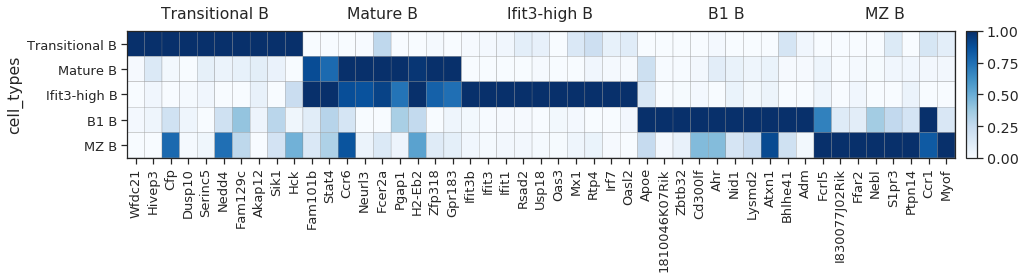

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[15.040000000000001, 0, 0.2])

In [67]:
# Plot top genes in a heatmap (matrixplot in scanpy)

sc.pl.matrixplot(
    Brna_adata,
    B_marker_genes, # as a dictionary, will be sorted
    groupby="cell_types",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Blues",
    var_group_rotation = 0,
    #swap_axes = True,
    save = "Bcell_RNA_changemode.pdf"
)


### Plot top DE proteins

In [68]:
# Collect top three proteins for each B cell cluster
# Save markers as a dictionary for them to be sorted in scanpy

B_categories = Bcell_clust_onevall

B_marker_proteins = {}
all_marker_proteins = []
for cluster in range(len(Bcell_res_onevall)):
    cluster_markers = []
    
    protein_de_filt = Bcell_res_onevall[cluster]
    protein_de_filt = protein_de_filt.loc[protein_de_filt['mean'] > 0] 
    protein_de_filt = protein_de_filt.loc[protein_de_filt['bayes_factor'] > .7] 
    protein_de_filt = protein_de_filt.sort_values(by = "median", ascending = False) 
    protein_de_filt = protein_de_filt.iloc[protein_de_filt.index.str.contains("ADT_")]                              
    protein = protein_de_filt.index[0:3].values
    
    # Make sure markers are unique
    for i in range(len(protein)):
        if protein[i] not in all_marker_proteins:
            cluster_markers.append(protein[i])
            all_marker_proteins.append(protein[i])

    B_marker_proteins[B_categories[cluster]] = [s.split("_")[1].split("(")[0] for s in cluster_markers]

In [69]:
all_marker_proteins

['ADT_CD93(AA4.1_earlyBlineage)_A0113',
 'ADT_CD24_A0212',
 'ADT_CD102_A0104',
 'ADT_IgD_A0571',
 'ADT_CD23_A0108',
 'ADT_CD62L_A0112',
 'ADT_integrinb7_A0214',
 'ADT_CD172a(SIRPa)_A0422',
 'ADT_CD43_A0110',
 'ADT_Ly-6A-E(Sca-1)_A0130',
 'ADT_CD86_A0200',
 'ADT_CD21-CD35(CR2-CR1)_A0107']

In [71]:
# Some top DE proteins are DE for multiple clusters
# For each unique feature in all_markers, find which cluster it belongs to (highest LFC) and add it to the dictionary

B_marker_proteins_clustered = {}

for feature in all_marker_proteins:
    LFC_for_feature = all_de.loc[feature].reset_index() # LFC for this feature in all clusters
    cluster_membership = all_de.loc[feature]["clusters"].iloc[LFC_for_feature["median"].idxmax()] # cluster number where feature has highest LFC
    if cluster_membership in B_marker_proteins_clustered.keys():
        B_marker_proteins_clustered[cluster_membership].append(feature.split("_")[1].split("(")[0])
    else:
        B_marker_proteins_clustered[cluster_membership] = [feature.split("_")[1].split("(")[0]]

# Remake dictionary to match the order of the cell types
B_marker_proteins = {}
for cell_type in Bprotein_adata.obs["cell_types"].cat.categories.values:
    if cell_type in B_marker_proteins_clustered.keys():
        B_marker_proteins[cell_type] = B_marker_proteins_clustered[cell_type]

print(B_marker_proteins)

{'Transitional B': ['CD93', 'CD24', 'CD102'], 'Mature B': ['IgD', 'CD23', 'CD62L', 'integrinb7'], 'B1 B': ['CD172a', 'CD43', 'Ly-6A-E'], 'MZ B': ['CD86', 'CD21-CD35']}


In [72]:
# Make dendrogram for proteins

sc.tl.dendrogram(Bprotein_adata, use_rep="X", groupby="cell_types")

In [ ]:
# Abbreviate protein names for plotting

Bprotein_adata_abbrev = Bprotein_adata.copy()
Bprotein_adata_abbrev.var.index = ([s.split("_")[1].split("(")[0] for s in Bprotein_adata_abbrev.var.index.values])

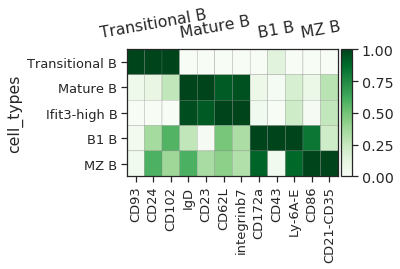

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[3.84, 0, 0.2])

In [74]:
# Plot top proteins in a heatmap (matrixplot in scanpy)

sc.pl.matrixplot(
    Bprotein_adata_abbrev,
    B_marker_proteins, # as a dictionary, will be sorted
    groupby="cell_types",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Greens",
    var_group_rotation = 10,
    #swap_axes = True,
    save = "Bcell_protein_changemode.pdf"
)

### One-vs-one DE: Ifit3-high B vs mature B     

Find if there are any protein markers that distinguish the Ifit3-high B cell cluster from the mature B cell cluster.

In [20]:
# Find cell types for DE

group1 = np.where(np.array(dataset.cell_types) == "Ifit3-high B")[0]
group2 = np.where(np.array(dataset.cell_types) == "Mature B")[0]

labels = dataset.labels.ravel() # Label corresponds to the index from cell_types above

In [25]:
# Run one-vs-one DE test

ifit3_vs_mature_de = full_posterior.differential_expression_score(
    idx1=labels==group1,
    idx2=labels==group2,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [26]:
# DE RNA results

ifit3_RNA = ifit3_vs_mature_de.loc[ifit3_vs_mature_de['non_zeros_proportion1'] > 0.1]
ifit3_RNA = ifit3_RNA.sort_values(by = "median", ascending = False) 
ifit3_RNA = ifit3_RNA.loc[ifit3_RNA['bayes_factor'] > .7] 
ifit3_RNA = ifit3_RNA.iloc[~ifit3_RNA.index.str.contains("ADT_")]              
ifit3_RNA

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_min,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
Ifit3b,0.9854,0.0146,4.212025,0.000178,0.000003,5.138502,5.016537,3.104330,-6.874916,17.326744,...,-0.680725,11.289148,-2.018480,13.331038,0.225211,0.002214,0.116833,0.002013,0.759632,0.006410
Ifit3,0.9876,0.0124,4.377580,0.000809,0.000017,4.964268,4.850960,2.840726,-4.627563,15.269474,...,-0.722690,10.305529,-1.997800,12.033524,1.003843,0.016304,0.305150,0.012379,3.487104,0.046753
Ifit1,0.9810,0.0190,3.944133,0.000266,0.000009,4.542067,4.453032,2.664748,-4.175858,14.710499,...,-0.424545,9.829305,-1.819715,11.269169,0.377402,0.009461,0.166795,0.007850,1.278450,0.027129
Rsad2,0.9832,0.0168,4.069433,0.000261,0.000007,4.424438,4.356966,2.808978,-5.872102,14.502176,...,-1.041727,9.891453,-2.367404,11.808804,0.277479,0.007146,0.157571,0.005938,0.952061,0.020458
Usp18,0.9842,0.0158,4.131819,0.000327,0.000017,3.667156,3.563566,2.196061,-3.641350,11.358831,...,-0.586173,8.012078,-1.315294,9.727883,0.340507,0.016103,0.216756,0.013587,1.291156,0.053140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Blk,0.7640,0.2360,1.174736,0.000433,0.000559,-0.375880,-0.362017,0.569717,-2.683463,2.002974,...,-1.549655,0.749073,-1.934175,1.117798,0.456572,0.622081,0.338201,0.402778,1.742838,2.237664
Sept11,0.7874,0.2126,1.309324,0.000153,0.000210,-0.420919,-0.365651,0.740207,-3.609313,1.875702,...,-1.974689,0.958158,-2.699826,1.295365,0.154497,0.245773,0.132206,0.185085,0.597627,0.848947
Adgre5,0.7890,0.2110,1.318908,0.000405,0.000527,-0.395185,-0.365810,0.700477,-3.287589,2.446186,...,-1.825599,0.950720,-2.276230,1.375245,0.378939,0.557568,0.275942,0.359199,1.538854,2.118507
Il4i1,0.8780,0.1220,1.973625,0.000458,0.000679,-0.408310,-0.376048,1.393105,-7.686493,5.481964,...,-2.987659,2.621945,-4.464709,3.397955,0.508071,0.776671,0.275942,0.343096,1.946669,2.851148


In [27]:
# DE protein results

ifit3_protein = ifit3_vs_mature_de
ifit3_protein = ifit3_protein.loc[ifit3_protein['bayes_factor'] > .7] 
ifit3_protein = ifit3_protein.sort_values(by = "median", ascending = False) 
ifit3_protein = ifit3_protein.iloc[ifit3_protein.index.str.contains("ADT_")]                                 
ifit3_protein

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_min,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
ADT_Ly-6A-E(Sca-1)_A0130,0.7818,0.2182,1.276187,43.037418,37.481743,0.367290,0.129993,4.201657,-9.133993,9.269262,...,-7.283667,7.374205,-8.034262,7.988477,46.853191,40.487217,1.000000,1.000000,NaN,NaN
ADT_CD62L_A0112,0.7088,0.2912,0.889563,88.093956,84.279121,0.174678,0.069812,2.684021,-9.030524,9.193121,...,-7.427691,7.361618,-7.972154,8.542645,87.438896,83.713264,0.998463,0.998692,NaN,NaN
ADT_integrinb7_A0214,0.6684,0.3316,0.700957,27.229984,26.445368,0.172098,0.032797,1.884456,-7.226636,7.027030,...,-1.327159,6.348159,-6.193074,6.664444,27.155266,26.921297,1.000000,0.999899,NaN,NaN
ADT_CD79b(Igb)_A0561,0.6880,0.3120,0.790786,31.730007,32.859142,-0.009079,-0.008793,0.630155,-6.050469,6.782924,...,-1.125584,1.157085,-1.664032,1.621872,31.291315,32.556259,1.000000,0.999899,NaN,NaN
ADT_CD55(DAF)_A0558,0.6758,0.3242,0.734537,108.144714,111.980453,-0.015686,-0.018049,0.598764,-2.476763,8.743111,...,-1.195049,1.144649,-1.608735,1.579824,105.813988,110.479469,1.000000,1.000000,NaN,NaN
ADT_IgD_A0571,0.7334,0.2666,1.011942,393.798340,406.501160,-0.005861,-0.019041,0.948201,-10.135212,10.311149,...,-1.523299,1.740145,-2.509719,2.863615,397.070709,404.654602,1.000000,1.000000,NaN,NaN
ADT_CD24_A0212,0.7612,0.2388,1.159270,67.032158,79.016266,-0.149128,-0.058430,0.913156,-3.208118,2.637214,...,-2.220109,1.608788,-2.773479,2.022586,68.394310,80.804955,1.000000,0.999899,NaN,NaN
ADT_CD150(SLAM)_A0203,0.6960,0.3040,0.828322,26.266644,27.997620,-0.079823,-0.071748,1.150525,-7.436171,6.947563,...,-1.379791,1.082973,-6.173983,5.591435,25.395081,27.857086,1.000000,0.999799,NaN,NaN
ADT_CD29_A0570,0.7572,0.2428,1.137389,9.913052,11.818398,-0.089750,-0.076416,2.866146,-8.230511,6.869244,...,-5.384512,5.135578,-5.936182,5.833424,11.101460,13.615338,0.999231,0.999295,NaN,NaN
ADT_CD102_A0104,0.7028,0.2972,0.860667,42.943550,48.800598,-0.125287,-0.084472,0.742299,-7.826140,7.232934,...,-1.463926,1.010182,-1.970527,1.410923,41.973099,49.077293,1.000000,1.000000,NaN,NaN


## Intra-cluster correlations

Explore intra-cluster feature correlations in transitional and mature B cells

### Calculate correlations within clusters

In [28]:
# Get all feature names

gene_protein_names = np.concatenate((dataset.gene_names, dataset.protein_names))

In [29]:
# Calculate correlations in transitional B cells

transitional_clusters = [
    c in ["3"]
    for c in post_adata.obs["leiden_subclusters"]
]

# Create posterior on subset of the data
transitional_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset))[transitional_clusters], type_class=TotalPosterior
)

# Calculate totalVI correlations
transitional_corr_totalVI_spearman = transitional_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", 
                                                                 log_transform = True,
                                                                 rna_size_factor = 1e4,
                                                                 transform_batch = 0)[0,:,:]

In [30]:
# Calculate correlations in mature B cells

mature_clusters = [
    c in ["1", "4", "5", "7", "9"]
    for c in post_adata.obs["leiden_subclusters"]
]

# Create posterior on subset of the data
mature_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset))[mature_clusters], type_class=TotalPosterior
)

# Calculate totalVI correlations
mature_corr_totalVI_spearman = mature_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", 
                                                                 log_transform = True,
                                                                 rna_size_factor = 1e4,
                                                                 transform_batch = 0)[0,:,:]

### One-vs-one DE: transitional B vs mature B

Select 10 RNA markers and 3 protein markers for each cluster.

In [31]:
# Find cell types for DE

group1 = np.where(np.array(dataset.cell_types) == "Transitional B")[0]
group2 = np.where(np.array(dataset.cell_types) == "Mature B")[0]

labels = dataset.labels.ravel()

In [32]:
# Run one vs one DE test

transitional_vs_mature_de = full_posterior.differential_expression_score(
    idx1=labels==group1,
    idx2=labels==group2,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [33]:
# DE RNA results: transitional markers

transitional_RNA = transitional_vs_mature_de.loc[transitional_vs_mature_de['non_zeros_proportion1'] > 0.1]
transitional_RNA = transitional_RNA.sort_values(by = "median", ascending = False) 
transitional_RNA = transitional_RNA.loc[transitional_RNA['bayes_factor'] > .7] 
transitional_RNA = transitional_RNA.iloc[~transitional_RNA.index.str.contains("ADT_")]                                
transitional_RNA = transitional_RNA.index[0:10].values 
transitional_RNA

array(['Wfdc21', 'Cfp', 'Hivep3', 'Dusp10', 'Nedd4', 'Serinc5', 'Fam129c',
       'Sik1', 'Hck', 'Akap12'], dtype=object)

In [34]:
# DE RNA results: mature markers

mature_RNA = transitional_vs_mature_de.loc[transitional_vs_mature_de['non_zeros_proportion2'] > 0.1] 
mature_RNA = mature_RNA.sort_values(by = "median", ascending = True) 
mature_RNA = mature_RNA.loc[mature_RNA['bayes_factor'] > .7] 
mature_RNA = mature_RNA.iloc[~mature_RNA.index.str.contains("ADT_")]                             
mature_RNA = mature_RNA.index[0:10].values 
mature_RNA

array(['Fam101b', 'Apoe', 'Stat4', 'Gimap4', 'H2-Eb2', 'Ccr6', 'Bmyc',
       'Hcst', 'Gpr174', 'Ptpn7'], dtype=object)

In [51]:
# DE protein results: transitional markers

transitional_protein = transitional_vs_mature_de
transitional_protein = transitional_protein.loc[transitional_protein['bayes_factor'] > .7] 
transitional_protein = transitional_protein.sort_values(by = "median", ascending = False) 
transitional_protein = transitional_protein.iloc[transitional_protein.index.str.contains("ADT_")]                                
transitional_protein = transitional_protein.index[0:3].values
transitional_protein

array(['ADT_CD93(AA4.1_earlyBlineage)_A0113', 'ADT_CD24_A0212',
       'ADT_CD43_A0110'], dtype=object)

In [36]:
# DE protein results: mature markers

mature_protein = transitional_vs_mature_de
mature_protein = mature_protein.loc[mature_protein['bayes_factor'] > .7] 
mature_protein = mature_protein.sort_values(by = "median", ascending = True) 
mature_protein = mature_protein.iloc[mature_protein.index.str.contains("ADT_")]                                   
mature_protein = mature_protein.index[0:3].values
mature_protein

array(['ADT_CD62L_A0112', 'ADT_Ly-6A-E(Sca-1)_A0130',
       'ADT_integrinb7_A0214'], dtype=object)

In [37]:
# Collect markers for each cell type

transitional_markers = np.concatenate((transitional_RNA, transitional_protein))
mature_markers = np.concatenate((mature_RNA, mature_protein))

### Plot correlations in transitional and mature B cells

Look for correlated modules in DE features and addtional correlated genes.

In [38]:
# Find top correlates with the above markers

# highly correlated with transitional markers in transitional
corr_totalVI_df_transitional = pd.DataFrame(transitional_corr_totalVI_spearman, columns = gene_protein_names, index = gene_protein_names)

corr_transitional = []
for feature in transitional_markers: 
    sorted_corr = corr_totalVI_df_transitional.loc[feature].sort_values(axis = 0, ascending = False)
    sorted_corr = sorted_corr.index.values[0:5] # top correlated features (first will be itself)
    corr_transitional.extend(sorted_corr)

# highly correlated with mature markers in mature
corr_totalVI_df_mature = pd.DataFrame(mature_corr_totalVI_spearman, columns = gene_protein_names, index = gene_protein_names)

corr_mature = []
for feature in mature_markers: 
    sorted_corr = corr_totalVI_df_mature.loc[feature].sort_values(axis = 0, ascending = False) 
    sorted_corr = sorted_corr.index.values[0:5] # top correlated features (first will be itself)
    corr_mature.extend(sorted_corr)


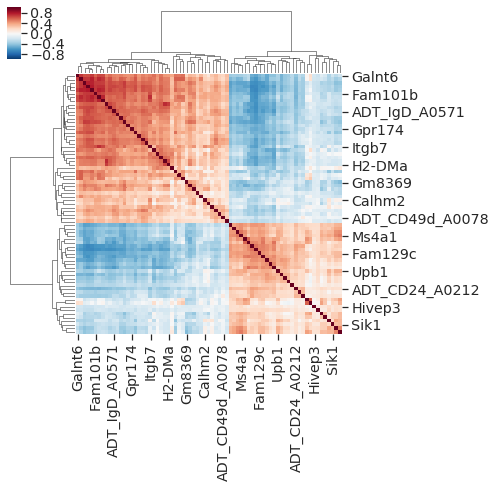

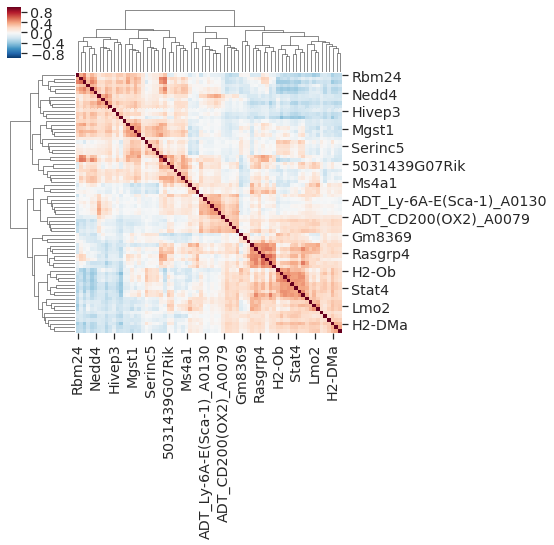

In [40]:
# Plot the feature correlations
# Subset the data to the selected correlation matrix

transitional_mature_markers = np.concatenate((np.unique(corr_transitional), np.unique(corr_mature)))

corr_totalVI_df_transitional = pd.DataFrame(transitional_corr_totalVI_spearman, columns = gene_protein_names, index = gene_protein_names).loc[transitional_mature_markers, transitional_mature_markers]
corr_totalVI_df_mature = pd.DataFrame(mature_corr_totalVI_spearman, columns = gene_protein_names, index = gene_protein_names).loc[transitional_mature_markers, transitional_mature_markers]

# Plot totalVI spearman correlations heatmaps
transitional_heatmap = sns.clustermap(corr_totalVI_df_transitional, cmap="RdBu_r", center=0, 
                    vmin = -1, 
                    vmax = 1, 
                    metric = "euclidean",
                    figsize = (6,6))

mature_heatmap = sns.clustermap(corr_totalVI_df_mature, cmap="RdBu_r", center=0, 
                    vmin = -1, 
                    vmax = 1, 
                    metric = "euclidean",
                    figsize = (6,6))

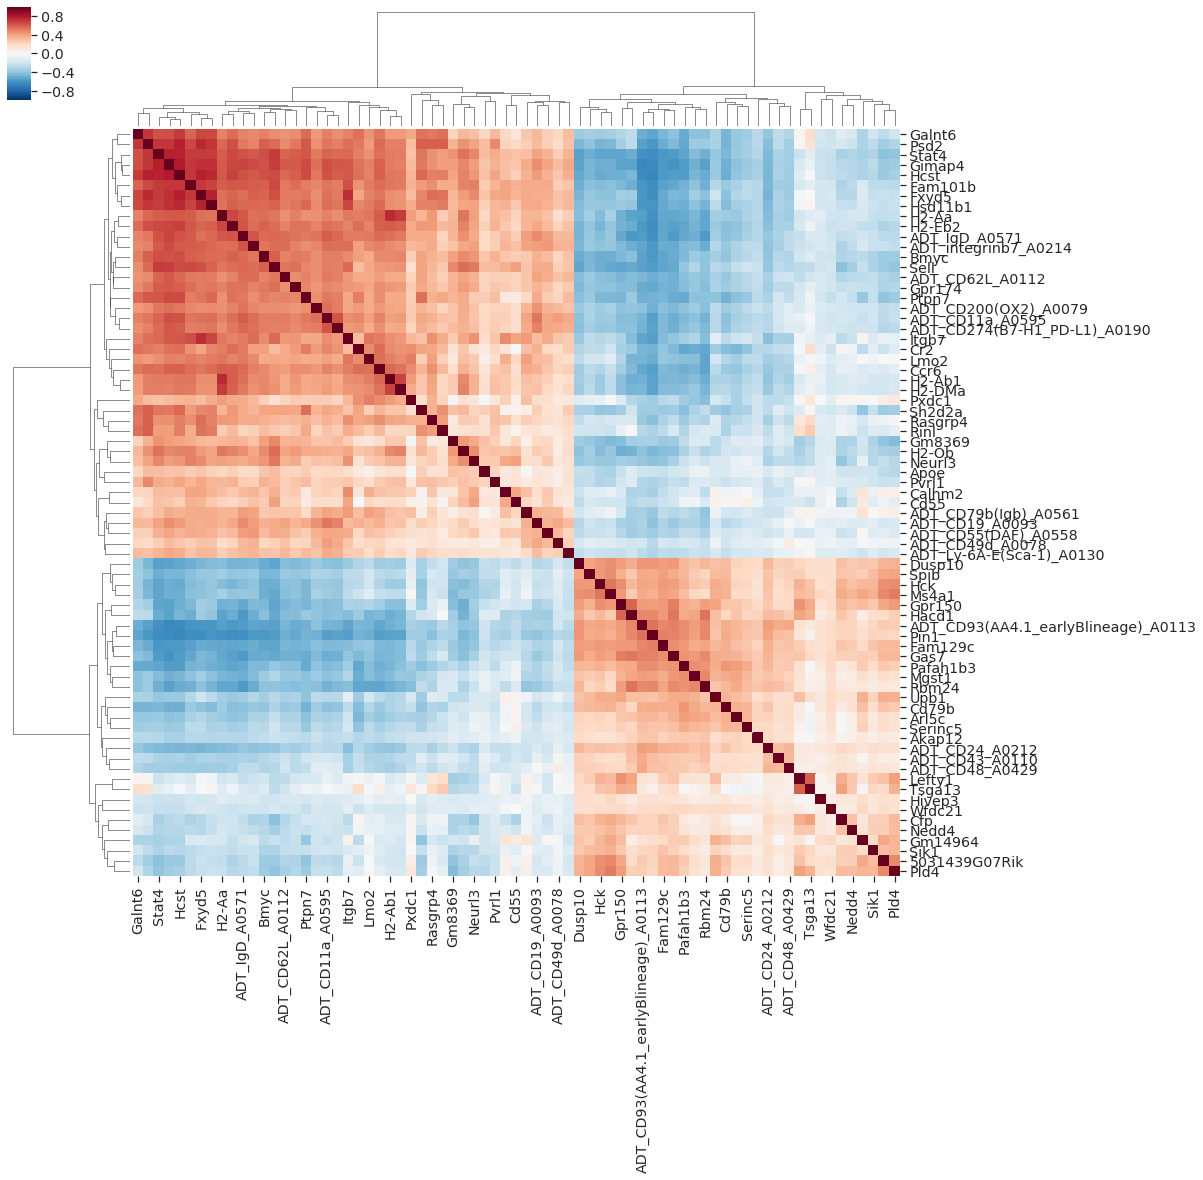

In [41]:
# Transitional plot (with all feature names)
transitional_heatmap = sns.clustermap(corr_totalVI_df_transitional, cmap="RdBu_r", center=0, 
                    vmin = -1, 
                    vmax = 1, 
                    metric = "euclidean",
                    yticklabels = True,
                    figsize = (16,16))

#### Plot transitional correlations with annotations

In [42]:
# Get ordered gene names
transitional_ordered = transitional_heatmap.dendrogram_row.reordered_ind
reordered_transitional_names = corr_totalVI_df_transitional.iloc[transitional_ordered, transitional_ordered].index

In [43]:
# Add feature annotations to plot
is_protein = ["Protein" if corr_totalVI_df_transitional.loc[[feature]].index.str.contains("ADT_") 
              else "RNA" for feature in corr_totalVI_df_transitional.index.values]

labels = ["RNA", "Protein"]
network_pal = np.array(colors)[[5,4]] 
network_pal_ser = pd.Series(network_pal).astype("category")
network_lut = dict(zip(map(str, labels), network_pal_ser))
network_colors = pd.Series(is_protein).astype('category').loc[transitional_ordered].map(network_lut).values 

In [44]:
# Add cluster annotations to plot
is_correlated = ["Transitional B" if feature in corr_transitional 
              else "Mature B" if feature in corr_mature
                 else None
                 for feature in corr_totalVI_df_transitional.index.values]

labels2 = ["Mature B", "Transitional B"]
network_pal2 = np.array(colors)[[0, 1]]
network_pal_ser2 = pd.Series(network_pal2).astype("category")
network_lut2 = dict(zip(map(str, labels2), network_pal_ser2))
network_colors2 = pd.Series(is_correlated).astype('category').loc[transitional_ordered].map(network_lut2).values

In [45]:
# Make list of select markers to label
abbrev_transitional = [s.split("_")[1].split("(")[0] if "ADT_" in s else s for s in reordered_transitional_names]

select_features = ["CD93", "CD24", "Wfdc21", "IgD", "Ccr6", "Stat4"]
label_features  =["" if feature not in select_features
                 else feature for feature in abbrev_transitional]

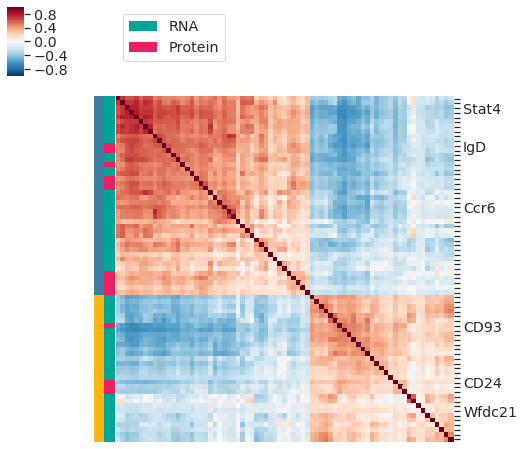

In [46]:
# Plot Spearman totalVI without dendrogram
fig = sns.clustermap(corr_totalVI_df_transitional.iloc[transitional_ordered, transitional_ordered], 
                    cmap="RdBu_r", center=0, 
                    vmin = -1, 
                    vmax = 1, 
                    metric = "euclidean",
                    row_colors = [network_colors2, network_colors],
                    col_cluster = False,
                    row_cluster = False,
                    yticklabels = label_features,
                    xticklabels = False,
                    figsize = (8,8))

for label in labels:
    fig.ax_col_dendrogram.bar(0, 0, color=network_lut[label],
                            label=label, linewidth=0)
fig.ax_col_dendrogram.legend(loc="upper left", ncol=1)

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Intra_transitional_corr.pdf", dpi=DPI, bbox_inches='tight')

#### Plot mature correlations with annotations

In [52]:
# Get ordered gene names
mature_ordered = mature_heatmap.dendrogram_row.reordered_ind
reordered_mature_names = corr_totalVI_df_mature.iloc[mature_ordered, mature_ordered].index

In [53]:
# Add feature annotations to plot
is_protein = ["Protein" if corr_totalVI_df_mature.loc[[feature]].index.str.contains("ADT_") 
              else "RNA" for feature in corr_totalVI_df_mature.index.values]

labels = ["RNA", "Protein"]
network_pal = np.array(colors)[[5,4]]
network_pal_ser = pd.Series(network_pal).astype("category")
network_lut = dict(zip(map(str, labels), network_pal_ser))
network_colors = pd.Series(is_protein).astype('category').loc[mature_ordered].map(network_lut).values # categorical

In [54]:
# Add cluster annotations to plot
is_correlated = ["Transitional B" if feature in corr_transitional 
              else "Mature B" if feature in corr_mature
                 else None
                 for feature in corr_totalVI_df_mature.index.values]

labels2 = ["Mature B", "Transitional B"] # Includes "None" as the last cluster
network_pal2 = np.array(colors)[[0, 1]] # 4, 5 is pink, blue
network_pal_ser2 = pd.Series(network_pal2).astype("category")
network_lut2 = dict(zip(map(str, labels2), network_pal_ser2))

network_colors2 = pd.Series(is_correlated).astype('category').loc[mature_ordered].map(network_lut2).values # categorical

In [55]:
# Make list of select markers to label
abbrev_mature = [s.split("_")[1].split("(")[0] if "ADT_" in s else s for s in reordered_mature_names]

select_features = ["CD93", "CD24", "Wfdc21", "IgD", "Ccr6", "Stat4"]
label_features  =["" if feature not in select_features
                 else feature for feature in abbrev_mature]

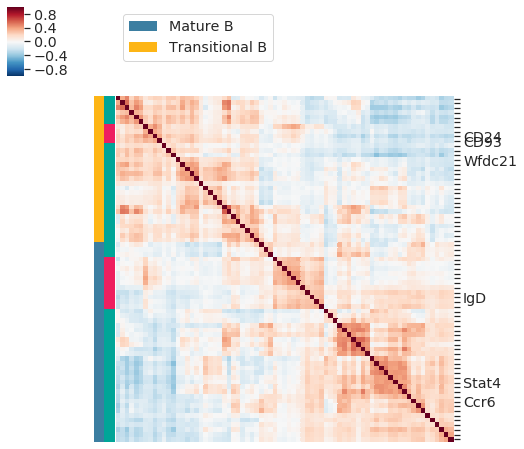

In [56]:
# Plot Spearman totalVI without dendrogram
fig = sns.clustermap(corr_totalVI_df_mature.iloc[mature_ordered, mature_ordered], 
                    cmap="RdBu_r", center=0, 
                    vmin = -1, 
                    vmax = 1, 
                    metric = "euclidean",
                    row_colors = [network_colors2, network_colors],
                    col_cluster = False,
                    row_cluster = False,
                    yticklabels = label_features,
                    xticklabels = False,
                   figsize = (8,8))

for label in labels2:
    fig.ax_col_dendrogram.bar(0, 0, color=network_lut2[label],
                            label=label, linewidth=0)
fig.ax_col_dendrogram.legend(loc="upper left", ncol=1)

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Intra_mature_corr.pdf", dpi=DPI, bbox_inches='tight')

### Rag1 and Z_16

Rag1 (indicator of early development) is expressed in a few early transitional B cells. The cells with high values in latent dimension 16 also express Rag1, and then gradually decrease in value as the transitional B cells approach mature B cells.

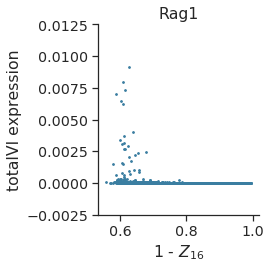

In [88]:
# Plot Rag1 vs latent dimension 16 in all B cells

fig, ax = plt.subplots(figsize = (4,4)) 

ax.scatter(1 - Brna_adata.obsm["X_totalVI"][:,19],
           (Brna_adata.X[:, Brna_adata.var.index == "Rag1"]),
          s = 3, rasterized = True, color = colors[0])
ax.set(xlabel = r"1 - $Z_{16}$")
ax.set(ylabel = "totalVI expression")
ax.set(title = "Rag1")
ax.set_ylim((-.0025, .0125))

sns.despine()
plt.tight_layout()

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Z16_Rag1_scatter.pdf", dpi=DPI, bbox_inches='tight')

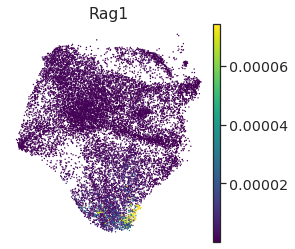

In [89]:
# Plot denoised Rag1 expression on UMAP

fig, ax = plt.subplots(figsize = (4, 4))
RNA = "Rag1"

sc.pl.umap(
        Brna_adata, 
        use_raw = False,
        color=RNA, # , 
        ncols=1, 
        color_map = "viridis",
        frameon = False,
        ax = ax,
        vmax = "p99.5",
        vmin = "p0.5",
        show = False
    )

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/%s_umap_RNA_denoised.pdf" % RNA, dpi=DPI, bbox_inches='tight')

In [90]:
# Add latent dimension 16 to adata object so it can be plotted
# Latent dimension 19 is labeled as Z_16 due to removal of dead dimensions

Brna_adata.obs["Z_16"] = Brna_adata.obsm["X_totalVI"][:,19] 

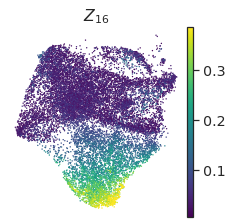

In [91]:
# Plot latent dimension 16 values on UMAP

fig, ax = plt.subplots(figsize = (3.5, 3.5))

sc.pl.umap(
        Brna_adata, 
        use_raw = False,
        color="Z_16", # , 
        ncols=1, 
        title = r"$Z_{16}$",
        color_map = "viridis",
        frameon = False,
        ax = ax,
        vmax = "p99.5",
        #vmin = "p0.5",
        show = False
    )

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Z16_umap.pdf", dpi=DPI, bbox_inches='tight')

### Plot module expression in transitional B cells

Order cells by early to late development using latent dimension 19 (named 16 due to removal of dead dimensions).
All features can be plotted together after standard scaling.

In [58]:
# Find transitional B cells

transitional_Bcells = [
    c in ["3"]
    for c in Brna_adata.obs["leiden_subclusters"]
]

In [65]:
# Collect denoised RNA and protein data to plot, and latent space

rna_data = pd.DataFrame((Brna_adata.X[transitional_Bcells, :]), columns = Brna_adata.var.index)
protein_data = pd.DataFrame((Bprotein_adata.X[transitional_Bcells, :]), columns = Bprotein_adata.var.index)

latent_data = pd.DataFrame(Brna_adata.obsm["X_totalVI"][transitional_Bcells, :], columns = np.array(range(0,20)).astype(str))

archetype_data = pd.concat([latent_data, rna_data, protein_data], axis = 1)
archetype_data.shape

(2735, 4135)

In [66]:
# Find features to plot

df_prot = np.concatenate((np.array(["19"]), np.array([marker for marker in transitional_mature_markers 
                                            if "ADT_" in marker])))

df_rna = np.concatenate((np.array(["19"]), np.array([marker for marker in transitional_mature_markers 
                                            if "ADT_" not in marker])))

In [67]:
# Subset expression data by features to plot

sub_archetype_rna = archetype_data.loc[:, df_rna] 
sub_archetype_protein = archetype_data.loc[:, df_prot]

In [70]:
# Standard scale all RNA and protein features

archetype_all = pd.concat([sub_archetype_rna.iloc[:, 1:], sub_archetype_protein.iloc[:, 1:]], axis = 1)
x = StandardScaler().fit_transform(X = np.asarray(archetype_all))

scaled_features = pd.DataFrame(x, columns = archetype_all.columns)

In [72]:
# Add latent dimension data
# Max value of a latent dimension is 1 (the archetype). Use 1 - Z_16 to orient from highest to lowest in this dimension.

scaled_features["Z_16"] = 1 - sub_archetype_rna["19"]

In [74]:
# Melt scaled features for plotting with ggplot

arch_melt_scaled = pd.melt(scaled_features,
                    id_vars = "Z_16",
                    value_vars = archetype_all.columns)

arch_melt_scaled

,Z_16,variable,value
0,0.683332,5031439G07Rik,1.520834
1,0.596773,5031439G07Rik,0.920898
2,0.760528,5031439G07Rik,1.282005
3,0.750603,5031439G07Rik,0.110351
4,0.896505,5031439G07Rik,-1.285972
...,...,...,...
199650,0.634267,ADT_integrinb7_A0214,-0.888817
199651,0.628835,ADT_integrinb7_A0214,-0.888817
199652,0.843238,ADT_integrinb7_A0214,1.579139
199653,0.765238,ADT_integrinb7_A0214,-0.754873


In [75]:
# Add column for each variable to indicate whether it is transitional/mature correlated

cluster_id_scaled = ["Transitional B" if feature in np.unique(corr_transitional)
             else "Mature B" if feature in np.unique(corr_mature)
              else None
             for feature in arch_melt_scaled[["variable"]].values]

arch_melt_scaled["cluster_id"] = cluster_id_scaled
arch_melt_scaled

,Z_16,variable,value,cluster_id
0,0.683332,5031439G07Rik,1.520834,Transitional B
1,0.596773,5031439G07Rik,0.920898,Transitional B
2,0.760528,5031439G07Rik,1.282005,Transitional B
3,0.750603,5031439G07Rik,0.110351,Transitional B
4,0.896505,5031439G07Rik,-1.285972,Transitional B
...,...,...,...,...
199650,0.634267,ADT_integrinb7_A0214,-0.888817,Mature B
199651,0.628835,ADT_integrinb7_A0214,-0.888817,Mature B
199652,0.843238,ADT_integrinb7_A0214,1.579139,Mature B
199653,0.765238,ADT_integrinb7_A0214,-0.754873,Mature B


In [76]:
# Make a cluster/feature id to distinguish RNA and protein

cluster_feature_id_scaled = ["Transitional B RNA" if ((feature in np.unique(corr_transitional)) & ("ADT_" not in feature))
                             else "Transitional B Protein" if ((feature in np.unique(corr_transitional)) & ("ADT_" in feature))
                             else "Mature B RNA" if ((feature in np.unique(corr_mature)) & ("ADT_" not in feature))
                             else "Mature B Protein" if ((feature in np.unique(corr_mature)) & ("ADT_" in feature))
              else None
             for feature in arch_melt_scaled[["variable"]].values.ravel()]

arch_melt_scaled["cluster_feature_id_scaled"] = cluster_feature_id_scaled

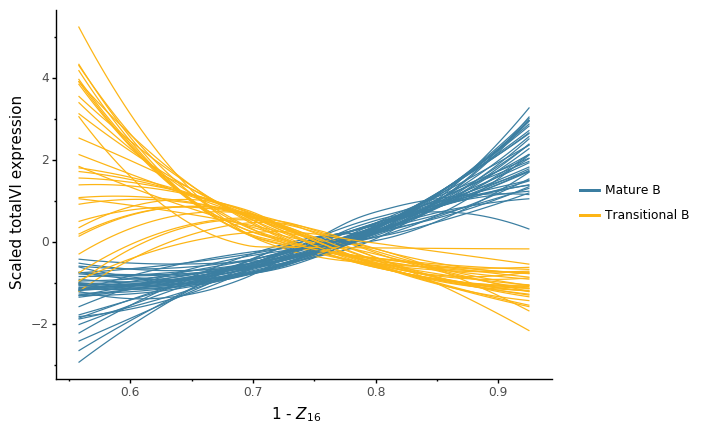

<ggplot: (8732991672329)>

In [77]:
# Plot all features along 1 - Z_16 axis

fig = (ggplot(arch_melt_scaled, aes(x = "Z_16", y = "value", group = "variable", color = "cluster_id_scaled")) +
    geom_smooth(se = False, method = "loess", alpha = 0.4, size = 0.5) +
    theme_classic() +
    scale_color_manual(values = np.array(colors)[[0,1]]) +
    labs(x = "1 - $Z_{16}$", y = "Scaled totalVI expression", color = "")
    )

fig

fig.save("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Z16_vs_feature_lines.pdf", height = 4, width = 4, dpi = DPI)


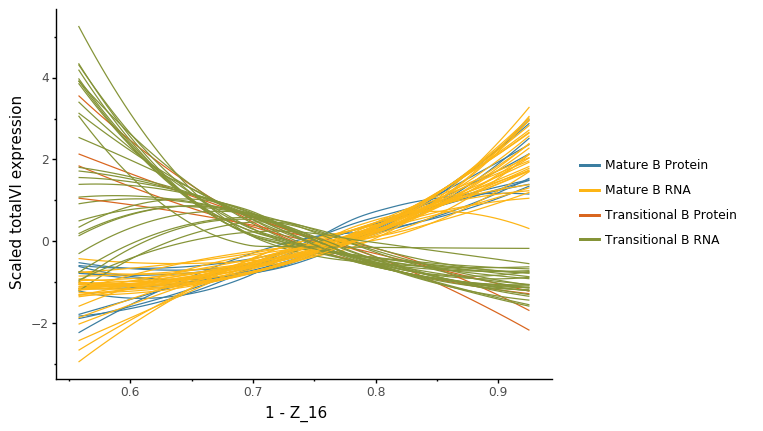

<ggplot: (8732991562053)>

In [78]:
# Plot RNA and protein separately (trend is the same)

fig = (ggplot(arch_melt_scaled, aes(x = "Z_16", y = "value", group = "variable", color = "cluster_feature_id_scaled")) +
    geom_smooth(se = False, method = "loess", alpha = 0.9, size = 0.5) + 
    theme_classic() +
    scale_color_manual(values = np.array(colors)[[0, 1, 2, 3]]) +
    labs(x = "1 - Z_16", y = "Scaled totalVI expression", color = "") 
    )

fig

### Calculate correlations between features and Z_16

In [81]:
# Find correlations between each feature and the latent dimension

archetype_corr_data = pd.concat([sub_archetype_rna, sub_archetype_protein.iloc[:, 1:]], axis = 1)
archetype_corr_data.iloc[:, 0] = 1 - archetype_corr_data.iloc[:, 0]
archetype_corr_data

,19,5031439G07Rik,Akap12,Arl5c,Cd79b,Cfp,Dusp10,Fam129c,Gas7,Gm14964,...,ADT_CD19_A0093,ADT_CD200(OX2)_A0079,ADT_CD274(B7-H1_PD-L1)_A0190,ADT_CD49d_A0078,ADT_CD55(DAF)_A0558,ADT_CD62L_A0112,ADT_CD79b(Igb)_A0561,ADT_IgD_A0571,ADT_Ly-6A-E(Sca-1)_A0130,ADT_integrinb7_A0214
0,0.683332,0.000294,0.000459,0.000730,0.015703,0.000230,0.000342,0.001114,0.000070,0.000076,...,67.135437,6.531329,0.000000,8.376573,42.973492,0.000000,24.452652,30.089649,0.000000,0.000000
1,0.596773,0.000258,0.000919,0.000824,0.015639,0.000150,0.000644,0.001701,0.000146,0.000046,...,62.836292,6.728247,0.294162,9.273618,49.877983,0.000000,17.846912,10.735476,0.000000,0.000000
2,0.760528,0.000280,0.000128,0.000247,0.010322,0.000580,0.000221,0.000610,0.000014,0.000029,...,93.567284,13.189469,8.664040,11.939864,45.022461,7.149640,32.077381,110.197197,4.759995,4.107100
3,0.750603,0.000208,0.000189,0.000500,0.012097,0.000255,0.000140,0.000899,0.000011,0.000019,...,115.458054,12.095098,8.683349,12.785925,47.574249,22.548317,25.460451,77.563972,37.619217,3.731139
4,0.896505,0.000123,0.000071,0.000190,0.009127,0.000040,0.000034,0.000222,0.000001,0.000008,...,106.747139,19.766804,10.847374,12.040751,94.556282,62.769169,32.082672,368.340271,12.748541,22.026941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730,0.634267,0.000305,0.000481,0.000541,0.014358,0.000272,0.000562,0.001337,0.000105,0.000064,...,58.082813,4.268641,0.000000,7.499186,46.306549,0.000000,18.852777,20.115923,0.000000,0.000000
2731,0.628835,0.000283,0.000635,0.000877,0.017033,0.000143,0.000347,0.001310,0.000059,0.000073,...,66.520477,6.137790,0.000000,8.222638,48.493240,0.000000,19.302153,21.983013,0.000000,0.000000
2732,0.843238,0.000188,0.000146,0.000430,0.010840,0.000071,0.000069,0.000255,0.000005,0.000062,...,99.356209,15.709821,11.648703,12.749255,87.770729,34.753857,39.661949,218.049805,29.873814,22.651047
2733,0.765238,0.000178,0.000112,0.000260,0.010344,0.000468,0.000145,0.000885,0.000009,0.000023,...,89.952126,12.503637,7.088525,10.299287,46.659313,6.961639,22.849007,87.733124,4.342835,1.229351


In [82]:
# Spearman correlations

spearman_archetype = spearmanr(archetype_corr_data, axis = 0)
spearman_archetype[0].shape # 0 is spearman correlation, 1 is p value

(74, 74)

In [83]:
# Make dataframe of correlation results
# Select the first column (correlation of the archetype with each feature), exclude 1st row (archetype with self)

spearman_arch_df = pd.concat([pd.Series(spearman_archetype[0][1:,0], name = "Spearman",index = archetype_corr_data.columns[1:]), 
                              pd.Series(spearman_archetype[1][1:,0], name = "p-value", index = archetype_corr_data.columns[1:])],
                            axis = 1,
                            )
spearman_arch_df

,Spearman,p-value
5031439G07Rik,-0.677366,0.000000e+00
Akap12,-0.876616,0.000000e+00
Arl5c,-0.775349,0.000000e+00
Cd79b,-0.854466,0.000000e+00
Cfp,-0.503744,5.903417e-176
...,...,...
ADT_CD62L_A0112,0.930550,0.000000e+00
ADT_CD79b(Igb)_A0561,0.578343,5.888998e-244
ADT_IgD_A0571,0.927748,0.000000e+00
ADT_Ly-6A-E(Sca-1)_A0130,0.803021,0.000000e+00


In [84]:
# Find adjusted p values of spearman correlations

_, pvals_adj, _, _ = multipletests(spearman_arch_df["p-value"].values, alpha=0.05, method="fdr_bh")
pvals_adj

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       6.33749215e-176, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       5.62976798e-162, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 2.36815402e-074, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 8.85154104e-305,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.93251115e-028, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.24513504e-119, 0.00000000e+000, 1.35990654e-099,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       4.64573714e-208, 0

In [85]:
# Find the highest p value (they are all significant)

np.max(pvals_adj)

1.9325111547568705e-28

In [86]:
# Add column for each variable to indicate whether it is transitional/mature correlated

is_correlated = ["Transitional B" if feature in corr_transitional 
              else "Mature B" if feature in corr_mature
                 else None
                 for feature in spearman_arch_df.index.values]

spearman_arch_df["cluster"] = is_correlated

spearman_arch_df

,Spearman,p-value,cluster
5031439G07Rik,-0.677366,0.000000e+00,Transitional B
Akap12,-0.876616,0.000000e+00,Transitional B
Arl5c,-0.775349,0.000000e+00,Transitional B
Cd79b,-0.854466,0.000000e+00,Transitional B
Cfp,-0.503744,5.903417e-176,Transitional B
...,...,...,...
ADT_CD62L_A0112,0.930550,0.000000e+00,Mature B
ADT_CD79b(Igb)_A0561,0.578343,5.888998e-244,Mature B
ADT_IgD_A0571,0.927748,0.000000e+00,Mature B
ADT_Ly-6A-E(Sca-1)_A0130,0.803021,0.000000e+00,Mature B


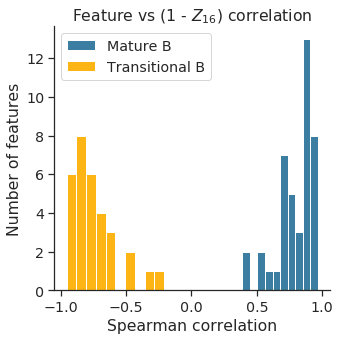

In [87]:
# Plot Spearman correlations between features and latent dimension as a histogram

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(spearman_arch_df.iloc[np.where(spearman_arch_df["cluster"] == "Mature B")]["Spearman"], 
        label = "Mature B"
       )
ax.hist(spearman_arch_df.iloc[np.where(spearman_arch_df["cluster"] == "Transitional B")]["Spearman"], 
        label = "Transitional B"
       )

ax.set(xlabel = "Spearman correlation")
ax.set(ylabel = "Number of features")
ax.set(title = 'Feature vs (1 - $Z_{16}$) correlation')
ax.legend()

sns.despine()
plt.tight_layout()

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/Bcell_figures/Z16_vs_feature_corr_histogram.pdf", dpi=DPI, bbox_inches='tight')